In [3]:
from causalsim import *
import metrics
from econml.metalearners import XLearner
from econml.dr import DRLearner
from econml.dml import CausalForestDML
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

## Data Generation 
#### Simple model: Treatment effect for individual i: \tau_i = \beta * x_{i1} 

In [4]:
n = 1000  # Number of individuals
p = 1     # Number of covariates
beta = 1  # Beta_1 value for treatment effect
sigma = 1 # Sigma value for noise term
data = simulation_simple(n = n, p = p, beta = beta, sigma = sigma)
print(data.head(10))

         X1       tau  Z   epsilon         Y
0  0.490606  0.490606  0  1.446427  1.446427
1 -0.398235 -0.398235  1  0.501608  0.103374
2  0.649832  0.649832  0 -1.034123 -1.034123
3  0.059713  0.059713  0  0.365180  0.365180
4  1.263940  1.263940  0 -0.879105 -0.879105
5  0.495692  0.495692  0 -0.278884 -0.278884
6  1.993849  1.993849  0  0.004528  0.004528
7 -1.326912 -1.326912  0 -1.079947 -1.079947
8  1.406814  1.406814  1  0.132280  1.539094
9  0.766703  0.766703  0  1.436465  1.436465


#### Categorical Model

In [40]:
n = 1000  # Number of individuals
p = 1     # Number of covariates
beta = 1  # Beta_1 value for treatment effect
sigma = 1 # Sigma value for noise term
data_cat = simulation_categorical(n = n, p = p, beta = beta, sigma = sigma)
print(data_cat.head(10))

         X1  tau  Z   epsilon         Y
0  0.832535    1  1 -0.840408  0.159592
1 -0.700517    0  1  1.325396  1.325396
2  0.634056    1  1 -0.693534  0.306466
3  0.033519    1  0  0.597293  0.597293
4  0.555514    1  1 -1.097726 -0.097726
5 -0.974944    0  1 -0.193595 -0.193595
6 -0.165101    0  0 -1.254151 -1.254151
7 -1.852704    0  1 -1.887995 -1.887995
8  1.391106    1  1  1.153587  2.153587
9  0.091190    1  1  2.471147  3.471147


#### Assigning variables for econml metalearner functions

In [6]:
X = data[[col for col in data.columns if col.startswith('X')]]
T = data['Z'] #treatment indicator
y = data['Y']
tau = np.array(data['tau'])

## Linear Regression

#### y ~ X + Z + X*Z

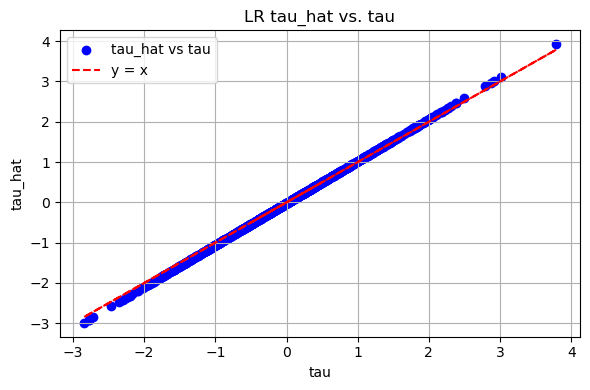

In [7]:
data['X1*Z'] = data['X1'] * data['Z'] #Setting interaction term
lr_xfit = data[['X1', 'Z', 'X1*Z']]

lr = LinearRegression() #Fit linear regression
lr.fit(lr_xfit, data['Y'])

bz = lr.coef_[1]
bzx = lr.coef_[2]

tau_hat_lr = bz + bzx*data['X1']


mse_lr, bias_lr, r2_lr = metrics.evaluate(tau, tau_hat_lr)

metrics.tau_plot(tau, tau_hat_lr, 'LR tau_hat vs. tau')

In [8]:
print(tau_hat_lr)

0      0.489182
1     -0.435620
2      0.654849
3      0.040855
4      1.293803
         ...   
995   -1.279491
996   -0.304061
997   -0.587184
998   -0.917392
999   -0.563287
Name: X1, Length: 1000, dtype: float64


In [9]:
print(f'LR metrics:\nMse: {mse_lr}\nBias: {bias_lr}\nR2 {r2_lr}')

LR metrics:
Mse: 0.0021446355443406383
Bias: 0.021949059932995545
R2 0.997888885659402


## X-Learner

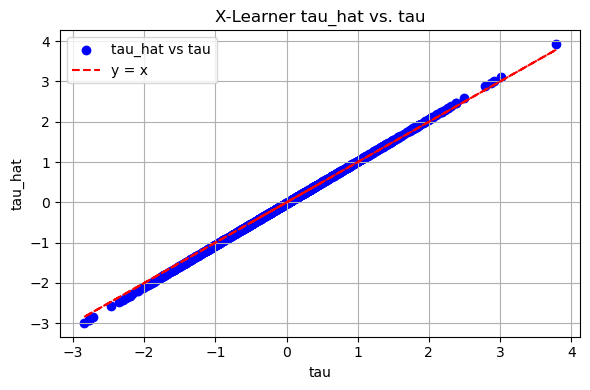

In [33]:
est = XLearner(models=LinearRegression())
est.fit(y, T, X=X)
tau_hat_x = est.effect(X)

mse_x, bias_x, r2_x = metrics.evaluate(tau, tau_hat_x)
metrics.tau_plot(tau, tau_hat_x, 'X-Learner tau_hat vs. tau')

In [36]:
print(f'X-learner metrics:\nMse: {mse_x}\nBias: {bias_x}\nR2 {r2_x}')

X-learner metrics:
Mse: 0.00214463554434062
Bias: 0.02194905993299553
R2 0.997888885659402


## DR-Learner

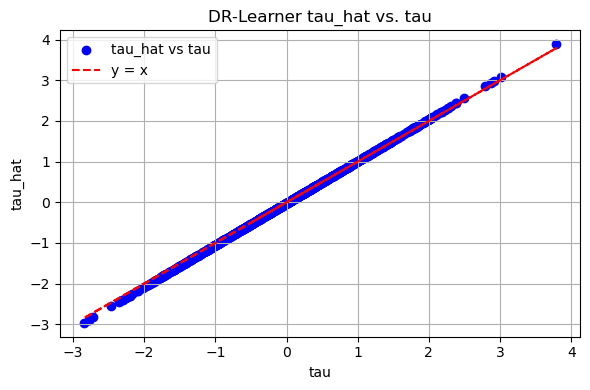

In [38]:
est = DRLearner()
est.fit(y, T, X=X, W=None)
tau_hat_dr = est.effect(X)

mse_dr, bias_dr, r2_dr = metrics.evaluate(tau, tau_hat_dr)
metrics.tau_plot(tau, tau_hat_dr, 'DR-Learner tau_hat vs. tau')

In [39]:
print(f'DR-learner metrics:\nMse: {mse_dr}\nBias: {bias_dr}\nR2 {r2_dr}')

DR-learner metrics:
Mse: 0.0014956527969684596
Bias: 0.023147456094419105
R2 0.9985277246399428


## Causal Forest

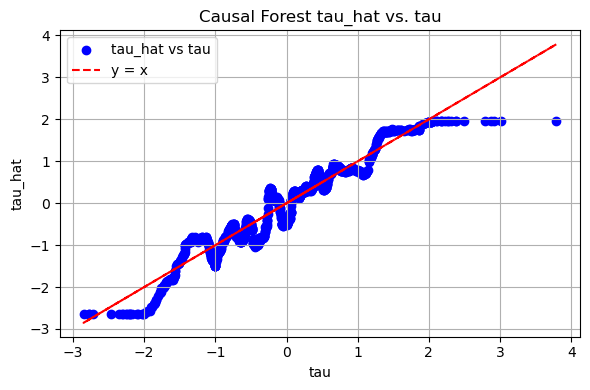

In [14]:
est = CausalForestDML(discrete_treatment=True)
est.fit(y, T, X=X, W=None)
tau_hat_cf = est.effect(X)

mse_cf, bias_cf, r2_cf = metrics.evaluate(tau, tau_hat_cf)
metrics.tau_plot(tau, tau_hat_cf, 'Causal Forest tau_hat vs. tau')

In [15]:
print(f'Causal Forest metrics:\nMse: {mse_cf}\nBias: {bias_cf}\nR2 {r2_cf}')

Causal Forest metrics:
Mse: 0.08616283649753598
Bias: 0.030176418012139876
R2 0.9151839107411266
